###U-NET BASED IMAGE SEGMENTATION

The U-Net is an elegant architecture that solves most of the occurring issues. It uses the concept of fully convolutional networks for this approach. The intent of the U-Net is to capture both the features of the context as well as the localization. This process is completed successfully by the type of architecture built. The main idea of the implementation is to utilize successive contracting layers, which are immediately followed by the upsampling operators for achieving higher resolution outputs on the input images.

We have done image segmentation of electron microscope generated images of neurons and brain cells using U-net architecture

DATSET USED : https://www.kaggle.com/datasets/kmader/electron-microscopy-3d-segmentation

IMPORTING DEPENDANCIES

In [ ]:
# Common
import os 
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python import keras
#from tensorflow.keras import utils


# Data 
from glob import glob
from tqdm import tqdm
from keras.utils import load_img , img_to_array , array_to_img

# Data Visualization
import matplotlib.pyplot as plt

In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


IMPORTING DATSET FROM KAGGLE

In [ ]:
import opendatasets as od
if not os.path.isdir("electron-microscopy-3d-segmentation"):
  od.download("https://www.kaggle.com/datasets/kmader/electron-microscopy-3d-segmentation")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: harshitmishra970
Your Kaggle Key: ··········


100%|██████████| 215M/215M [00:02<00:00, 92.3MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#for Trainning Data:
import tifffile as tiff
Train_images=tiff.imread("electron-microscopy-3d-segmentation/training.tif")
Train_masks=tiff.imread("electron-microscopy-3d-segmentation/training_groundtruth.tif")

In [ ]:
Train_images.shape

(165, 768, 1024)

In [ ]:
!pip install shortuuid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#making files for trainning data:
if not os.path.isdir("electron-microscopy-3d-segmentation/data/images"):
  os.makedirs("electron-microscopy-3d-segmentation/data/images")
if not os.path.isdir("electron-microscopy-3d-segmentation/data/masks"):
  os.makedirs("electron-microscopy-3d-segmentation/data/masks")

In [ ]:
#for trainning images
import cv2
import shortuuid
import numpy as np

#for uniquename
s=[]
for i in range(165):
  s.append(str(shortuuid.uuid()))
#images:
for img in range(Train_images.shape[0]):
    cv2.imwrite("electron-microscopy-3d-segmentation/data/images/{}.jpg".format(s[img]),Train_images[img])
#masks:
for img in range(Train_masks.shape[0]):
    cv2.imwrite("electron-microscopy-3d-segmentation/data/masks/{}_L.jpg".format(s[img]),Train_masks[img])

In [ ]:
print("No Images:",len(os.listdir("electron-microscopy-3d-segmentation/data/images")))
print("No masks:",len(os.listdir("electron-microscopy-3d-segmentation/data/masks")))

No Images: 165
No masks: 165


SO, we have total 165 images with their ground truth masks given

In [ ]:
from sklearn.model_selection import train_test_split

images=os.listdir("electron-microscopy-3d-segmentation/data/images")
masks=os.listdir("electron-microscopy-3d-segmentation/data/masks")


#splitting data in folders:
Train_images,Val_images,Train_masks,Val_masks=train_test_split(images,masks,test_size=.2,shuffle=True)

In [ ]:
print(Train_images[:3])
print(Train_masks[:3])

['PsS7vKuywR3cnnfVbqNKCd.jpg', 'haqUbW6H7HmsEWykPWhYQz.jpg', '2oQB8nkSt8hCVgTz96RERV.jpg']
['caDLVm2SHNRNrANDRwcwpN_L.jpg', 'a52dGXWVxtLGbC7rXTstWQ_L.jpg', 'd5bfYKVHBzEvqSRyxV7arH_L.jpg']


In [ ]:
import shutil as sh 
#for images:
for name in images :
  if name in Train_images:
    path2save="Train"
  if name in Val_images:
    path2save="Val"
  if not os.path.isdir("electron-microscopy-3d-segmentation/{}/images".format(path2save)):
      os.makedirs("electron-microscopy-3d-segmentation/{}/images".format(path2save))
  sh.move("electron-microscopy-3d-segmentation/data/images/{}".format(name),"electron-microscopy-3d-segmentation/{}/images/{}".format(path2save,name))

In [ ]:
#for masks:
for name in masks :
  if name in Train_masks:
    path2save="Train"
  if name in Val_masks:
    path2save="Val"
  if not os.path.isdir("electron-microscopy-3d-segmentation/{}/masks".format(path2save)):
      os.makedirs("electron-microscopy-3d-segmentation/{}/masks".format(path2save))
  sh.move("electron-microscopy-3d-segmentation/data/masks/{}".format(name),"electron-microscopy-3d-segmentation/{}/masks/{}".format(path2save,name))

In [ ]:
if os.path.exists("electron-microscopy-3d-segmentation/data"):
    sh.rmtree("electron-microscopy-3d-segmentation/data")
    print("File Deleted")

File Deleted


PREPROCESSING IMAGE FILES 

In [ ]:
#for loading & resize images:
import cv2
def Load_image(path,Size):
    img = cv2.imread(path)
    img=cv2.resize(img,(Size,Size))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img=img/255.
    return img

In [ ]:
#for pltoing Images:
import matplotlib.pyplot as plt
def show_image(image, title=None):
    plt.imshow(image,cmap='gray')
    plt.title(title)
    plt.axis('off')

LOADING IMAGE WITH THEIR MASKS

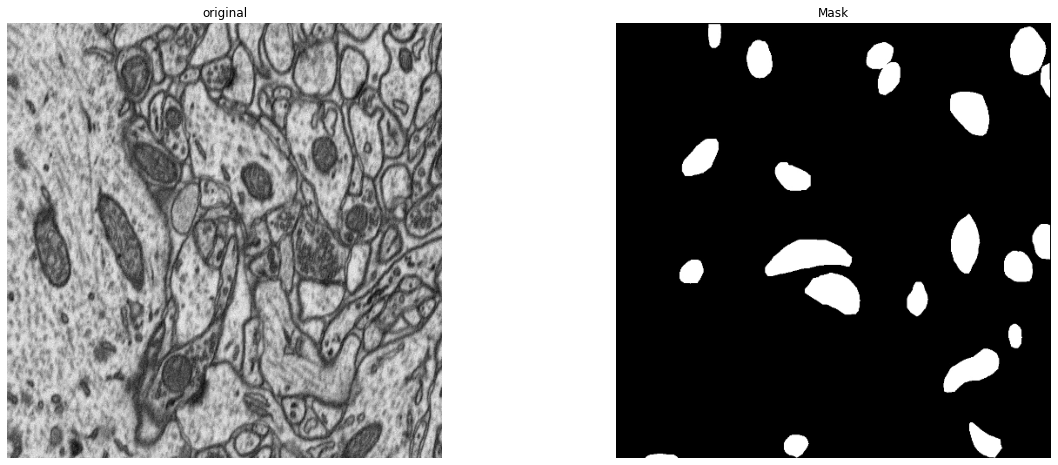

In [ ]:
#show perfect Size for images:
Size=500

img=os.listdir("electron-microscopy-3d-segmentation/Train/images")
mask=os.listdir("electron-microscopy-3d-segmentation/Train/masks")
image=Load_image("electron-microscopy-3d-segmentation/Train/images/{}".format(img[0]),Size)
label=Load_image("electron-microscopy-3d-segmentation/Train/masks/{}".format(mask[0]),Size)

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
show_image(image,"original")
plt.subplot(1,2,2)
show_image(label,"Mask")

##CREATING MODEL

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2DTranspose,ZeroPadding2D,Conv2D,Add,Dropout,Input,UpSampling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import load_img,img_to_array,plot_model 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint,EarlyStopping,Callback

In [ ]:
def decoder_block(input,skip_features, num_filters,conv_padding=False,zero_pad=False):

    x= Conv2DTranspose(num_filters, 2, activation = 'relu',strides=(2,2), kernel_initializer = 'he_normal')(input)

    if zero_pad == True:
      x=ZeroPadding2D((1,1))(x)
    
    if conv_padding ==True:
        x=Conv2D(num_filters, 3, activation = 'relu', padding='same', kernel_initializer = 'he_normal')(x)
    else:
        x=Conv2D(num_filters, 2, activation = 'relu', kernel_initializer = 'he_normal')(x)
    
    x = Add()([x, skip_features])
    return x

In [ ]:
def Unet_VGG19(input_size,n_classes):
    """ Input """
    inp = Input(input_size)
    """ Pre-trained Model """
    vgg19 = VGG19(include_top=False, weights="imagenet", input_tensor=inp)
    """ Encoder """
    E0=vgg19.get_layer("block1_conv2").output
    E0=Conv2D(128, 3, activation = 'relu', padding='same')(E0)
    E0=Conv2D(64, 3, activation = 'relu', padding='same')(E0)
    
    
    
    
    E1=vgg19.get_layer("block1_pool").output
    E1=Conv2D(128, 3, activation = 'relu', padding='same')(E1)
    E1=Conv2D(64, 3, activation = 'relu', padding='same')(E1)
    
    
    E2=vgg19.get_layer("block2_pool").output
    E2=Conv2D(128, 3, activation = 'relu', padding='same')(E2)
    
    
    E3=vgg19.get_layer("block3_pool").output
    E3=Conv2D(512, 3, activation = 'relu', padding='same')(E3)
    E3=Conv2D(256, 3, activation = 'relu', padding='same')(E3)
    
    
    E4=vgg19.get_layer("block4_pool").output
    E4=Conv2D(1024, 3, activation = 'relu', padding='same')(E4)
    E4=Conv2D(512, 3, activation = 'relu', padding='same')(E4)
    
    
    """ Bridge """
    B1=vgg19.get_layer("block5_pool").output
    B1=Conv2D(1024, 3, activation = 'relu', padding='same')(B1)
    
    """ Decoder """
    D1=decoder_block(B1,E4,512,zero_pad=True)
    
    
    D2=decoder_block(D1,E3,256,conv_padding=True)

    D3=decoder_block(D2,E2,128,zero_pad=True)

    D4=decoder_block(D3,E1,64,conv_padding=True)
    
    D5=decoder_block(D4,E0,64,conv_padding=True)

    """ Output """
    outputs=Conv2D(n_classes, 1, activation = 'sigmoid', padding = 'same')(D5)
    model = Model(inp,outputs, name="VGG19_U-Net")
    model.compile(optimizer = Adam(learning_rate = 1e-4), loss ='binary_crossentropy', metrics = ['accuracy' , tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1],threshold=0.6,name="IOU")])
    model.summary()
    return model

PRINTING MODEL ARCHITECTURE

In [ ]:
model=Unet_VGG19(input_size=(500,500,3),n_classes=1)

80134624/80134624 [==============================] - 1s 0us/step
Model: "VGG19_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500, 500, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 500, 500, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 500, 500, 64  36928       ['block1_conv1[0][0]']           
                       

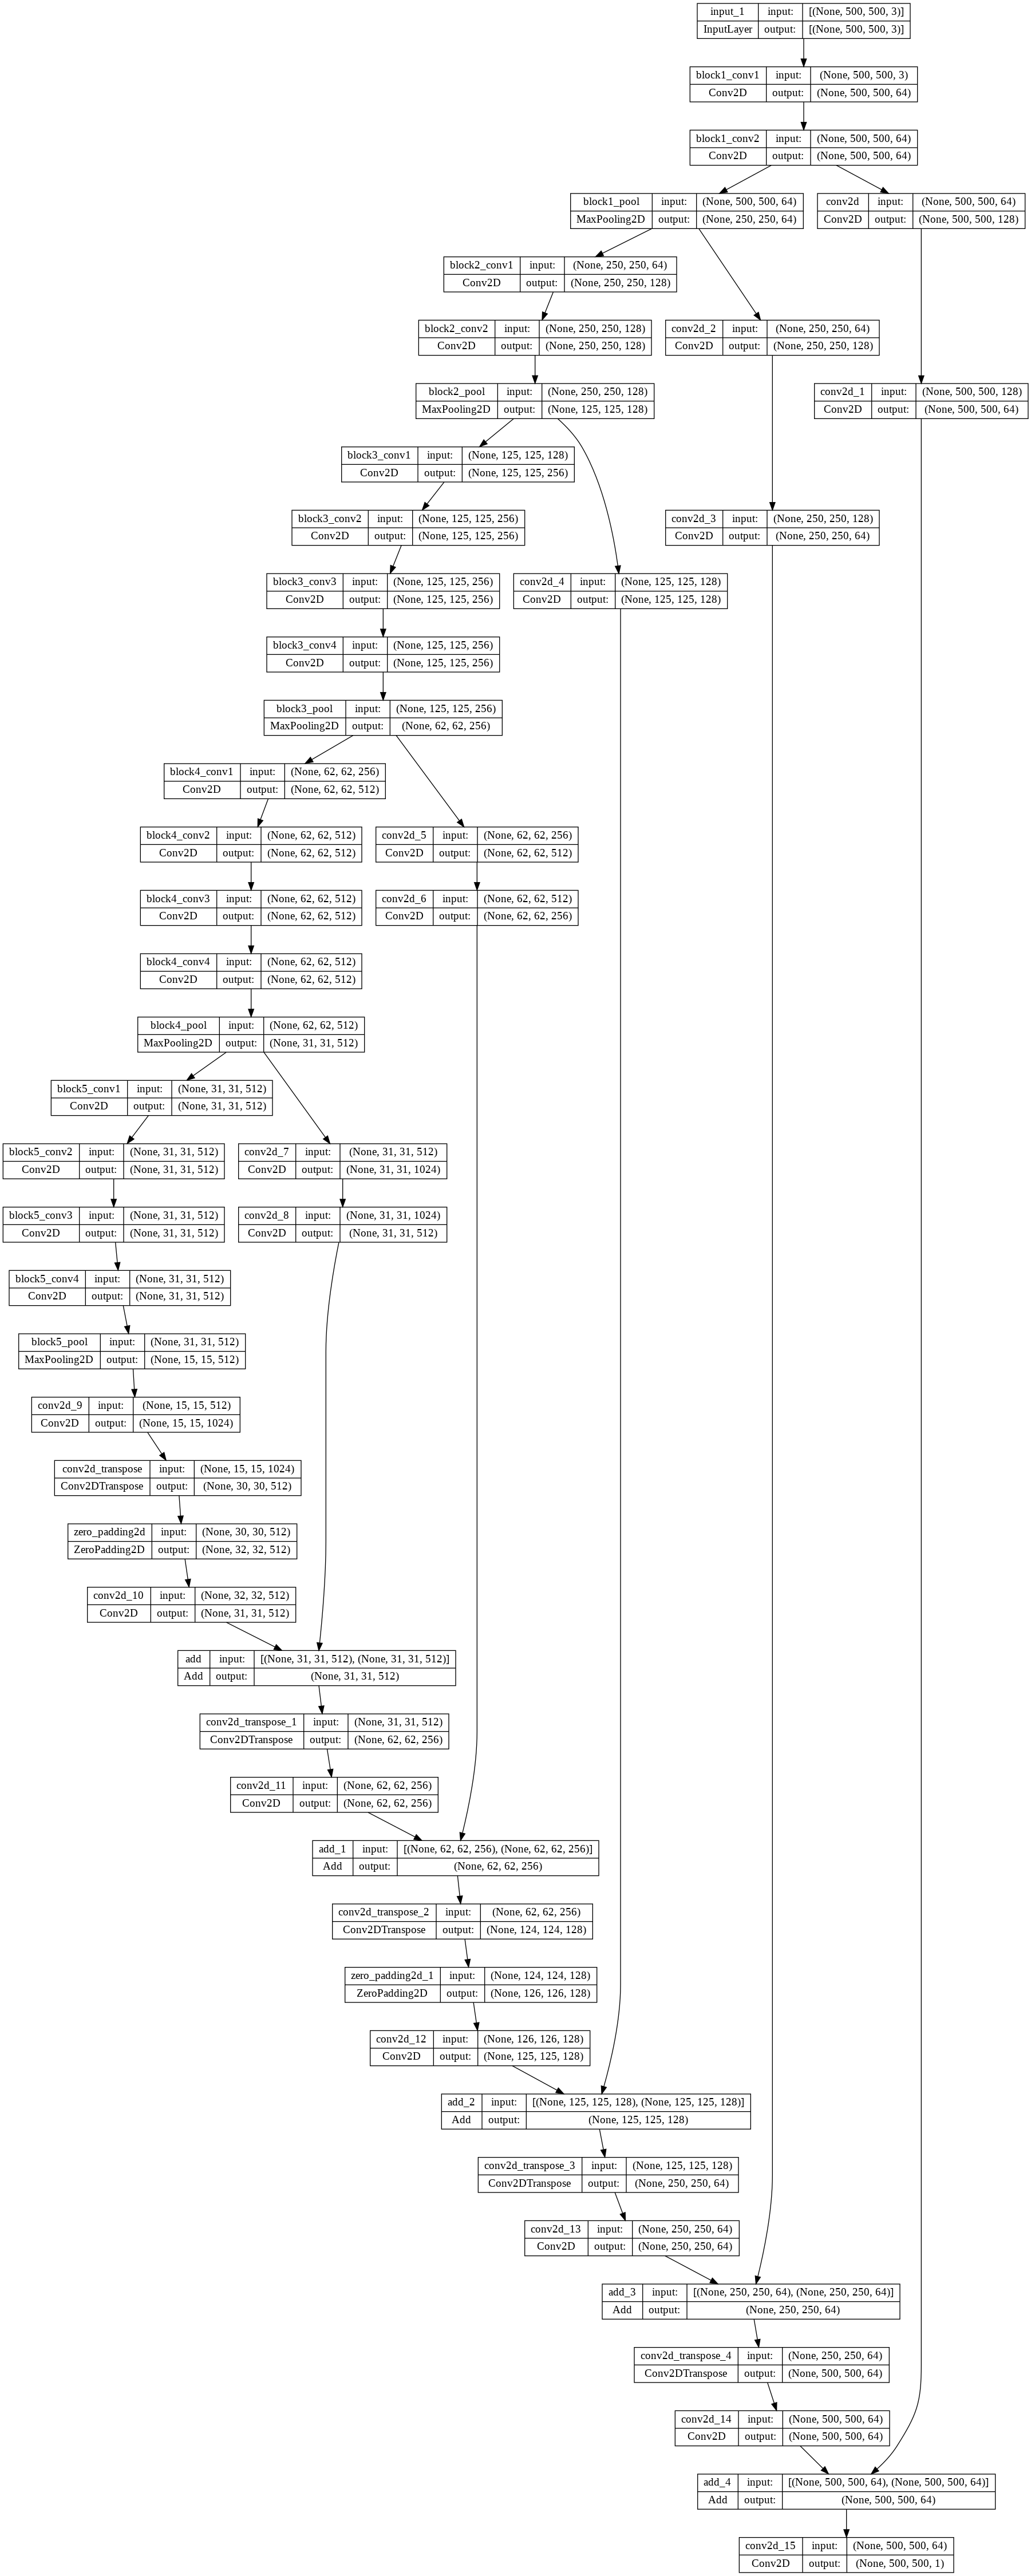

In [ ]:
plot_model(model,show_shapes=True,show_layer_names=True,expand_nested=True)

PREPARING TRAINING TRAINING DATA FOR FEEDING MODEL

In [ ]:
#for training data:
train_path="electron-microscopy-3d-segmentation/Train"

image_datagen = ImageDataGenerator(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    rescale=1/255.)
mask_datagen = ImageDataGenerator(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    rescale=1/255.)
B_size=8
seed = 1
image_generator = image_datagen.flow_from_directory(
    train_path,
    class_mode=None,
    classes=['images'],
    color_mode='rgb',
    seed=seed,
    batch_size=B_size,
    target_size=(500,500))

mask_generator = mask_datagen.flow_from_directory(
    train_path,
    classes=['masks'],
    color_mode='grayscale',
    class_mode=None,
    seed=seed,
    batch_size=B_size,
    target_size=(500,500))
# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

def train_generator_fn():

    for (img,mask) in train_generator:
        yield (img,mask)

Found 132 images belonging to 1 classes.
Found 132 images belonging to 1 classes.


In [ ]:
#for validation:
val_path="electron-microscopy-3d-segmentation/Val"

image_datagen = ImageDataGenerator(rescale=1/255.)
mask_datagen = ImageDataGenerator(rescale=1/255.)
B_size=8
seed = 1
image_generator = image_datagen.flow_from_directory(
    val_path,
    class_mode=None,
    classes=['images'],
    color_mode='rgb',
    seed=seed,
    batch_size=B_size,
    target_size=(500,500))

mask_generator = mask_datagen.flow_from_directory(
    val_path,
    classes=['masks'],
    color_mode='grayscale',
    class_mode=None,
    seed=seed,
    batch_size=B_size,
    target_size=(500,500))
# combine generators into one which yields image and masks
val_generator = zip(image_generator, mask_generator)

def val_generator_fn():

    for (img,mask) in val_generator:
        yield (img,mask)

Found 33 images belonging to 1 classes.
Found 33 images belonging to 1 classes.


Now, traing and testing our model for predictions

In [ ]:
#CallBacks and Model Fitting:
model_checkpoint = ModelCheckpoint('CheckPoint.hdf5', monitor='val_loss',verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=4, min_lr=1e-8)
Earlystop=EarlyStopping(monitor="val_loss",patience=6,mode="auto",restore_best_weights=True)

epochs=50
validation_steps=15
with tf.device('/gpu:0'):
    model.fit(train_generator_fn(),
                        validation_data=val_generator_fn(),
                        steps_per_epoch=60,
                        validation_steps=validation_steps,
                        epochs=epochs,
                        callbacks=[model_checkpoint,reduce_lr,Earlystop]
              )

Epoch 1/50
60/60 [==============================] - ETA: 0s - loss: 0.3263 - accuracy: 0.9029 - IOU: 0.4758
Epoch 1: val_loss improved from inf to 0.21238, saving model to CheckPoint.hdf5
60/60 [==============================] - 181s 2s/step - loss: 0.3263 - accuracy: 0.9029 - IOU: 0.4758 - val_loss: 0.2124 - val_accuracy: 0.9386 - val_IOU: 0.4752 - lr: 1.0000e-04
Epoch 2/50
60/60 [==============================] - ETA: 0s - loss: 0.2103 - accuracy: 0.9265 - IOU: 0.4791
Epoch 2: val_loss improved from 0.21238 to 0.20797, saving model to CheckPoint.hdf5
60/60 [==============================] - 132s 2s/step - loss: 0.2103 - accuracy: 0.9265 - IOU: 0.4791 - val_loss: 0.2080 - val_accuracy: 0.9383 - val_IOU: 0.4751 - lr: 1.0000e-04
Epoch 3/50
60/60 [==============================] - ETA: 0s - loss: 0.2002 - accuracy: 0.9267 - IOU: 0.4792
Epoch 3: val_loss improved from 0.20797 to 0.20319, saving model to CheckPoint.hdf5
60/60 [==============================] - 132s 2s/step - loss: 0.2002 -

In [ ]:
test=tiff.imread("electron-microscopy-3d-segmentation/testing.tif")
test_mask=tiff.imread("electron-microscopy-3d-segmentation/testing_groundtruth.tif")

In [ ]:
test.shape[0]

165

In [ ]:
#making files for trainning data:
if not os.path.isdir("electron-microscopy-3d-segmentation/Test/images"):
  os.makedirs("electron-microscopy-3d-segmentation/Test/images")
if not os.path.isdir("electron-microscopy-3d-segmentation/Test/masks"):
  os.makedirs("electron-microscopy-3d-segmentation/Test/masks")

In [ ]:
#for uniquename
s=[]
for i in range(test.shape[0]):
    s.append(str(shortuuid.uuid()))
#images:
for img in range(test.shape[0]):
      croped = test[img]
      cv2.imwrite("electron-microscopy-3d-segmentation/Test/images/{}.jpg".format(s[img]),croped)
#masks:
for img in range(test_mask.shape[0]):
      croped = test_mask[img]
      cv2.imwrite("electron-microscopy-3d-segmentation/Test/masks/{}_L.jpg".format(s[img]),croped)

In [ ]:
#for Testing data:
test_path="electron-microscopy-3d-segmentation/Test"
test_image_generator = image_datagen.flow_from_directory(
    test_path,
    class_mode=None,
    classes=['images'],
    color_mode='rgb',
    seed=seed,
    batch_size=B_size,
    target_size=(500,500))

test_mask_generator = mask_datagen.flow_from_directory(
    test_path,
    classes=['masks'],
    class_mode=None,
    seed=seed,
    color_mode='grayscale',
    batch_size=B_size,
    target_size=(500,500))

# combine generators into one which yields image and masks
test_generator = zip(test_image_generator, test_mask_generator)

def test_generator_fn():
    for (img,mask) in test_generator:
        yield (img,mask)  

Found 165 images belonging to 1 classes.
Found 165 images belonging to 1 classes.


In [ ]:
model.evaluate(test_generator_fn(),steps=165,batch_size=8)

165/165 [==============================] - 126s 766ms/step - loss: 0.1005 - accuracy: 0.9479 - IOU: 0.4790


[0.1004728451371193, 0.9479240775108337, 0.47899338603019714]

## SO WE HAVE GOT
#ACCURACY : 95%
#LOSS : 11%
#IOU : 0.47

1/1 [==============================] - 0s 355ms/step


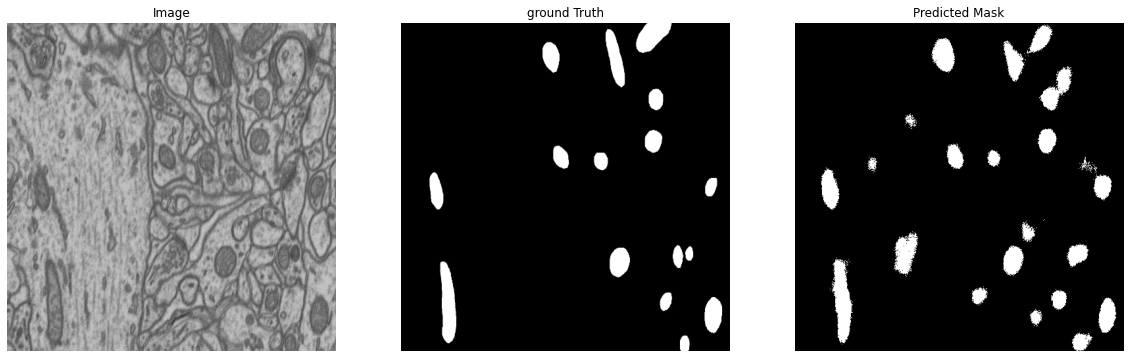

In [ ]:
index=np.random.randint(len(s))
size=500

img=cv2.imread("electron-microscopy-3d-segmentation/Test/images/{}.jpg".format(s[index]))
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img=cv2.resize(img,(size,size))
img=np.array(img)
img=img* 1/255.


maskpath= "electron-microscopy-3d-segmentation/Test/masks/{}_L.jpg".format(s[index])
mask= Load_image(maskpath,size)


image=np.expand_dims(img,axis=0)

result=model.predict(image)

result=np.uint8(result>=.22)

result=np.squeeze(result,axis=0)

result=np.squeeze(result,axis=-1)


#Ploting:
plt.figure(figsize=(20,12))

plt.subplot(1,3,1)
show_image(img,title="Image")

plt.subplot(1,3,2)
show_image(mask,title="ground Truth")


plt.subplot(1,3,3)
show_image(result,title="Predicted Mask")

In [ ]:
model.save("/content/drive/MyDrive/Electron Microscopy_segmentation2" , save_format="h5")